In [1]:
import pandas as pd
import numpy as np
#import haversine as hv
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import folium
import math
import matplotlib.pyplot as plt
from folium import plugins
from folium.plugins import HeatMap
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
la = pd.read_csv("la_2019.csv", parse_dates=["start_time","end_time"])

C:\Users\Lara\AppData\Local\Temp\ipykernel_15300\580411942.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  la = pd.read_csv("la_2019.csv", parse_dates=["start_time","end_time"])


In [3]:
# Überblick über Daten
print(la.head())
print(la.tail())

           start_time            end_time  start_station_id  end_station_id  \
0 2019-01-01 00:07:00 2019-01-01 00:14:00              3046            3051   
1 2019-01-01 00:08:00 2019-01-01 00:14:00              3046            3051   
2 2019-01-01 00:18:00 2019-01-01 00:50:00              3030            3075   
3 2019-01-01 00:20:00 2019-01-01 00:50:00              3030            3075   
4 2019-01-01 00:22:00 2019-01-01 00:50:00              3030            3075   

  bike_id user_type start_station_name end_station_name  
0   06468   Walk-up         2nd & Hill   7th & Broadway  
1   12311   Walk-up         2nd & Hill   7th & Broadway  
2   05992   Walk-up         Main & 1st   Broadway & 9th  
3   05860   Walk-up         Main & 1st   Broadway & 9th  
4   06006   Walk-up         Main & 1st   Broadway & 9th  
                start_time            end_time  start_station_id  \
290337 2019-12-31 23:35:51 2020-01-02 17:13:50              4491   
290338 2019-12-31 23:41:52 2019-12-31 23:

In [4]:
print(la.count())
print(la.info())

start_time            290342
end_time              290342
start_station_id      290342
end_station_id        290342
bike_id               290342
user_type             290342
start_station_name    290342
end_station_name      290342
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290342 entries, 0 to 290341
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   start_time          290342 non-null  datetime64[ns]
 1   end_time            290342 non-null  datetime64[ns]
 2   start_station_id    290342 non-null  int64         
 3   end_station_id      290342 non-null  int64         
 4   bike_id             290342 non-null  object        
 5   user_type           290342 non-null  object        
 6   start_station_name  290342 non-null  object        
 7   end_station_name    290342 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 17.7+ MB
None


In [5]:
la.isnull()

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
290337,False,False,False,False,False,False,False,False
290338,False,False,False,False,False,False,False,False
290339,False,False,False,False,False,False,False,False
290340,False,False,False,False,False,False,False,False


In [6]:
# hinzufügen der Dauer der Fahrt
la["duration"] = (la["end_time"] - la["start_time"]).astype("timedelta64[m]")
la["user_type"].size

290342

In [7]:
#remove data with same start and end station, that are shorter or equal to one minutes
print(la[((la["start_station_name"] == la["end_station_name"]) & (la["duration"] <= 1.0))].size)
filtered_data = la[ ~((la["start_station_name"] == la["end_station_name"]) & (la["duration"] <= 1.0)) ]

53325


# Add Cordinates to Data

In [8]:
# new data set with station information (locations)
# https://gbfs.bcycle.com/bcycle_lametro/station_information.json
coordinates = pd.read_csv("station_information.csv")
# drop unnecessary columns
coordinates = coordinates.drop(columns=['ttl', 'data__stations__rental_uris__ios','data__stations__rental_uris__android','version','last_updated'])
coordinates.head(3)

,data__stations__lon,data__stations__lat,data__stations___bcycle_station_type,data__stations__region_id,data__stations__address,data__stations__name,data__stations__station_id
0,-118.25854,34.04850,Kiosk and Station,bcycle_lametro_region_1,Reinstalled 6/15,7th & Flower,bcycle_lametro_3005
1,-118.25667,34.04554,Kiosk and Station,bcycle_lametro_region_1,729 S Olive Street,Olive & 8th,bcycle_lametro_3006
2,-118.25459,34.05048,Kiosk and Station,bcycle_lametro_region_1,557 S 5th Street,5th & Grand,bcycle_lametro_3007


In [9]:
# adding coordinates to stations
coordinates["ziped_coords_start"] = list(zip(coordinates["data__stations__lat"],coordinates["data__stations__lon"]))
la = la.merge(coordinates["ziped_coords_start"].to_frame(),how = "left",left_on=la["start_station_name"],right_on=coordinates["data__stations__name"])
la = la.drop(columns=["key_0"])
# dropping stations without location data
la = la.dropna(axis=0)
la.head(3)

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,ziped_coords_start
0,2019-01-01 00:07:00,2019-01-01 00:14:00,3046,3051,06468,Walk-up,2nd & Hill,7th & Broadway,7.0,"(34.05287, -118.24749)"
1,2019-01-01 00:08:00,2019-01-01 00:14:00,3046,3051,12311,Walk-up,2nd & Hill,7th & Broadway,6.0,"(34.05287, -118.24749)"
2,2019-01-01 00:18:00,2019-01-01 00:50:00,3030,3075,05992,Walk-up,Main & 1st,Broadway & 9th,32.0,"(34.05194, -118.24353)"


In [10]:
coordinates["ziped_coords_end"] = list(zip(coordinates["data__stations__lat"],coordinates["data__stations__lon"]))
la = la.merge(coordinates["ziped_coords_end"].to_frame(),how = "left",left_on=la["end_station_name"],right_on=coordinates["data__stations__name"])
la = la.drop(columns=["key_0"])

la = la.dropna(axis=0)
la.head(3)

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,ziped_coords_start,ziped_coords_end
2,2019-01-01 00:18:00,2019-01-01 00:50:00,3030,3075,05992,Walk-up,Main & 1st,Broadway & 9th,32.0,"(34.05194, -118.24353)","(34.04211, -118.25619)"
3,2019-01-01 00:20:00,2019-01-01 00:50:00,3030,3075,05860,Walk-up,Main & 1st,Broadway & 9th,30.0,"(34.05194, -118.24353)","(34.04211, -118.25619)"
4,2019-01-01 00:22:00,2019-01-01 00:50:00,3030,3075,06006,Walk-up,Main & 1st,Broadway & 9th,28.0,"(34.05194, -118.24353)","(34.04211, -118.25619)"


# CLUSTERING


### Calculate distance of the trip and distance to center for start point and end point

In [11]:
#distance 
# x and y coordinate of start and end point in lat1,lat2,lon1,lon2

la["lat1"], la["lon1"] = list(zip(*la["ziped_coords_start"]))
la["lat2"], la["lon2"] = list(zip(*la["ziped_coords_end"]))
lat1 = la["lat1"].tolist()
lat2 = la["lat2"].tolist()
lon1 = la["lon1"].tolist()
lon2 = la["lon2"].tolist()
listsize = len(lon2)

In [12]:
# method to calculate distance

distance = []
radius = 6371  # km

for n in range(listsize):
     
    dlat = math.radians(lat2[n] - lat1[n])
    dlon = math.radians(lon2[n] - lon1[n])
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1[n])) * math.cos(math.radians(lat2[n])) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c
    distance.append(round(d,2))
distance = list(distance)

In [13]:
# add distance to Dataset

la.insert(loc=0, column='distance', value=distance)

In [14]:
la

,distance,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,ziped_coords_start,ziped_coords_end,lat1,lon1,lat2,lon2
2,1.60,2019-01-01 00:18:00,2019-01-01 00:50:00,3030,3075,05992,Walk-up,Main & 1st,Broadway & 9th,32.0,"(34.05194, -118.24353)","(34.04211, -118.25619)",34.05194,-118.24353,34.04211,-118.25619
3,1.60,2019-01-01 00:20:00,2019-01-01 00:50:00,3030,3075,05860,Walk-up,Main & 1st,Broadway & 9th,30.0,"(34.05194, -118.24353)","(34.04211, -118.25619)",34.05194,-118.24353,34.04211,-118.25619
4,1.60,2019-01-01 00:22:00,2019-01-01 00:50:00,3030,3075,06006,Walk-up,Main & 1st,Broadway & 9th,28.0,"(34.05194, -118.24353)","(34.04211, -118.25619)",34.05194,-118.24353,34.04211,-118.25619
5,1.60,2019-01-01 00:23:00,2019-01-01 00:51:00,3030,3075,06304,Walk-up,Main & 1st,Broadway & 9th,28.0,"(34.05194, -118.24353)","(34.04211, -118.25619)",34.05194,-118.24353,34.04211,-118.25619
6,1.60,2019-01-01 00:24:00,2019-01-01 00:51:00,3030,3075,05846,Walk-up,Main & 1st,Broadway & 9th,27.0,"(34.05194, -118.24353)","(34.04211, -118.25619)",34.05194,-118.24353,34.04211,-118.25619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255636,0.60,2019-12-31 23:34:46,2019-12-31 23:42:28,3063,3069,12019,Walk-up,Pershing Square,Broadway & 3rd,7.0,"(34.04804, -118.25374)","(34.05088, -118.24825)",34.04804,-118.25374,34.05088,-118.24825
255637,0.00,2019-12-31 23:35:51,2020-01-02 17:13:50,4491,4491,5903,Monthly Pass,Main & Winston,Main & Winston,2497.0,"(34.04744, -118.24794)","(34.04744, -118.24794)",34.04744,-118.24794,34.04744,-118.24794
255638,1.38,2019-12-31 23:41:52,2019-12-31 23:50:58,4491,3022,18912,Monthly Pass,Main & Winston,3rd & Santa Fe,9.0,"(34.04744, -118.24794)","(34.04607, -118.23309)",34.04744,-118.24794,34.04607,-118.23309
255639,0.40,2019-12-31 23:48:17,2019-12-31 23:53:55,3064,3074,19053,Annual Pass,Grand & 8th,Hope & Olympic,5.0,"(34.04613, -118.25759)","(34.04417, -118.26117)",34.04613,-118.25759,34.04417,-118.26117


In [15]:
#City centre for distance calculation
la_centre = [34.052235, -118.243683]
la_centre_rad = [radians(_) for _ in la_centre]

la["start_dist_centre"] = la.apply(lambda x: (haversine_distances([[radians(_) for _ in la_centre], [radians(_) for _ in [x.lat1,x.lon1]]]))[0][1] * 6371000/1000, axis = 1)
la["end_dist_centre"] = la.apply(lambda x: (haversine_distances([[radians(_) for _ in la_centre], [radians(_) for _ in [x.lat2,x.lon2]]]))[0][1] * 6371000/1000, axis = 1)


In [16]:
# selecting distance, duration, start_dist_centre, end_dist_centre as attributes for clustering

la_cleaned = la
la_cleaned = la_cleaned.drop(columns=["start_time","end_time","start_station_id","end_station_id","bike_id","start_station_name","end_station_name","ziped_coords_start", "ziped_coords_end", "lat1", "lat2", "lon1", "lon2"])

X = la_cleaned.drop("user_type", axis=1)
y = la_cleaned["user_type"]
X.head()

,distance,duration,start_dist_centre,end_dist_centre
2,1.6,32.0,0.035703,1.611013
3,1.6,30.0,0.035703,1.611013
4,1.6,28.0,0.035703,1.611013
5,1.6,28.0,0.035703,1.611013
6,1.6,27.0,0.035703,1.611013


In [17]:
y.head()

2    Walk-up
3    Walk-up
4    Walk-up
5    Walk-up
6    Walk-up
Name: user_type, dtype: object

### Scaling

In [18]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_df.head()

,distance,duration,start_dist_centre,end_dist_centre
2,0.416712,0.042198,-0.603121,-0.349581
3,0.416712,0.026656,-0.603121,-0.349581
4,0.416712,0.011114,-0.603121,-0.349581
5,0.416712,0.011114,-0.603121,-0.349581
6,0.416712,0.003343,-0.603121,-0.349581


In [19]:
la_scaled = X_scaled_df
la_scaled["user_type"]=la["user_type"]

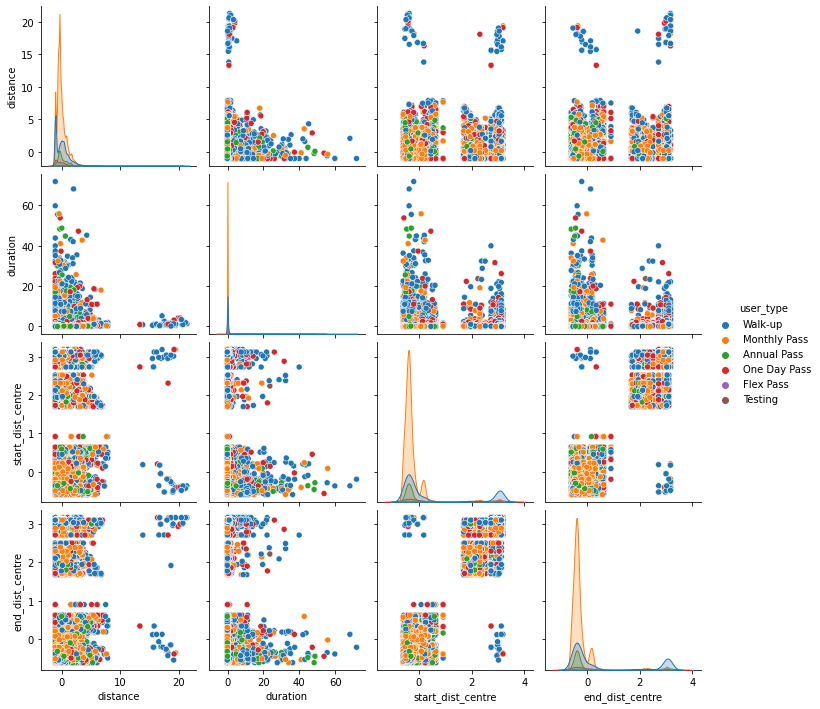

In [20]:
sns.pairplot(data=la_scaled,hue="user_type")

### Determination of good number of clusters

In [21]:
k_max = 15 #amount of clusters

In [22]:
clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters = k+1)
    model.fit(X_scaled)
    clusters.append(k+1)
    losses.append(model.inertia_)

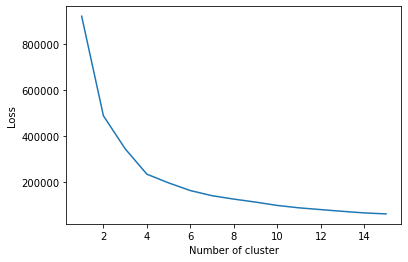

In [23]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of cluster")
plt.show()

(0.0, 10.0)

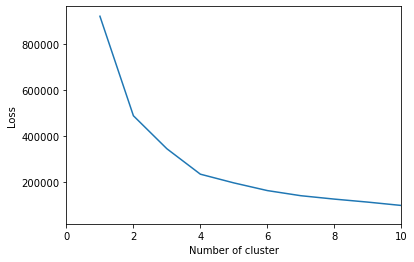

In [24]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of cluster")
plt.xlim([0,10])

### Select four for numbers of clusters (elbow method)

In [25]:
# refit algorithm
four_means = KMeans(n_clusters=4)
four_means.fit(X_scaled)

# match records to clusters by calling predict
four_means.predict(X_scaled)

array([0, 0, 0, ..., 0, 0, 0])

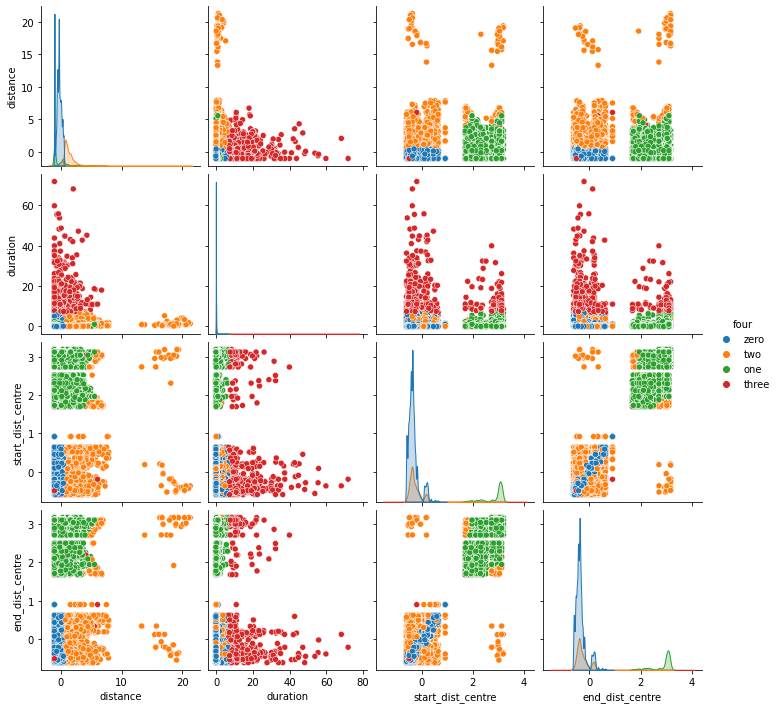

In [26]:
numbers = ["zero","one", "two", "three"]

la_scaled["four"] = four_means.predict(X_scaled)
la_scaled["four"] = la_scaled["four"].apply(lambda x : numbers[x])
sns.pairplot(data=la_scaled,hue="four")

### KMeans for six clusers (6 customer types initially)

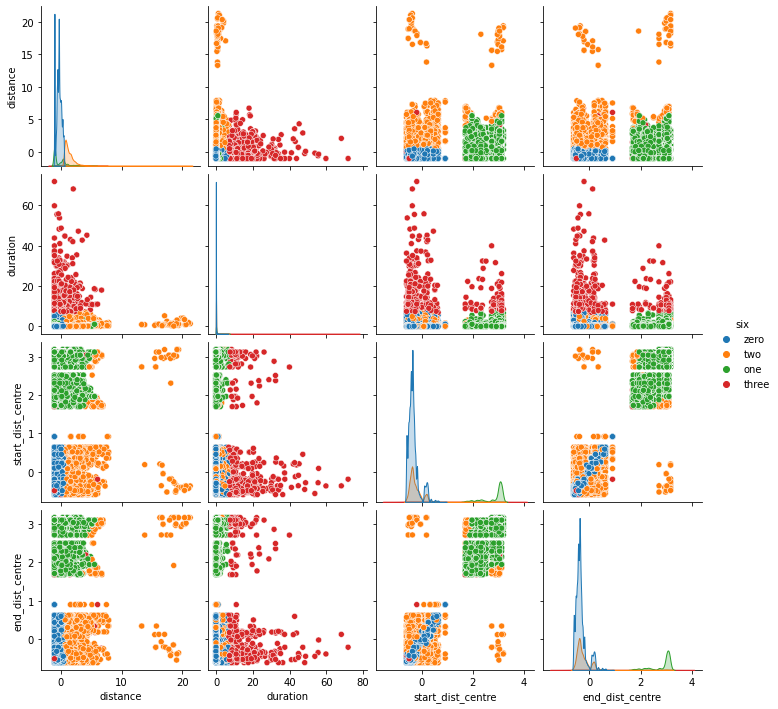

In [27]:
# correct nubers of clusters (6 customer)
# refit algorithm
six_means = KMeans(n_clusters=6)
six_means.fit(X_scaled)

la_scaled["six"] = four_means.predict(X_scaled)
la_scaled["six"] = la_scaled["six"].apply(lambda x : numbers[x])
sns.pairplot(data=la_scaled,hue="six")